About Dataset
This dataset supports research and development in real-time autonomous navigation within dynamic indoor environments, where mobile robots must make decisions by balancing multiple conflicting objectives.

📊 Key Features
Environment: Simulated indoor space with moving obstacles

Robot Platform: Mobile robot with simulated LIDAR, ultrasonic sensors, and motion tracking

Sensors:

LIDAR (min/max distances)

Ultrasonic (left/right proximity)

Battery usage

Position (x, y) and orientation

Collision flags

🏁 Objectives Included
Each navigation run aims to optimize:

⏱ Travel Time

⚡ Energy Efficiency

🤖 Collision Avoidance

🔄 Path Smoothness

🏷️ Target Labels
Each run is labeled with a performance class under the target column:

success – Goal reached with optimal performance

partial – Goal reached, but with suboptimal smoothness or high energy

collision – Collisions detected during navigation

timeout – Goal not reached within the time limit

📁 Dataset Structure
run_id: Unique identifier for each navigation session

timestamp: Time step of the current observation

lidar_min / lidar_max: Range of LIDAR readings

ultrasonic_left / ultrasonic_right: Proximity readings

x, y: Robot's position in 2D space

orientation: Heading direction (degrees)

battery_level: Remaining battery percentage

collision_flag: 1 if collision detected at that timestamp

path_smoothness: A score indicating path curvature

target: Final performance label for the run

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dynamic-indoor-robot-navigation-dataset/autonomous_navigation_dataset.csv


In [3]:
import pandas as pd

file_path = '/kaggle/input/dynamic-indoor-robot-navigation-dataset/autonomous_navigation_dataset.csv'
df = pd.read_csv(file_path)
print(df.head())


   run_id  timestamp  lidar_min  lidar_max  ultrasonic_left  ultrasonic_right  \
0       1          0       0.76       3.04             0.97              1.63   
1       1          1       2.16       4.84             0.95              0.82   
2       1          2       1.48       4.97             1.11              1.37   
3       1          3       0.66       4.32             1.24              0.86   
4       1          4       0.34       4.96             1.46              1.86   

      x     y  orientation  battery_level  collision_flag  path_smoothness  \
0  0.13  0.10       316.54          98.90               0             0.83   
1  0.14  0.43       253.94          98.32               0             0.83   
2  0.17  0.88       108.54          97.96               0             0.83   
3  0.46  1.24       314.48          97.26               0             0.83   
4  0.59  1.41       233.75          96.87               0             0.83   

   time_taken   target  
0          34  time

   run_id  timestamp  lidar_min  lidar_max  ultrasonic_left  ultrasonic_right  \
0       1          0       0.76       3.04             0.97              1.63   
1       1          1       2.16       4.84             0.95              0.82   
2       1          2       1.48       4.97             1.11              1.37   
3       1          3       0.66       4.32             1.24              0.86   
4       1          4       0.34       4.96             1.46              1.86   

      x     y  orientation  battery_level  collision_flag  path_smoothness  \
0  0.13  0.10       316.54          98.90               0             0.83   
1  0.14  0.43       253.94          98.32               0             0.83   
2  0.17  0.88       108.54          97.96               0             0.83   
3  0.46  1.24       314.48          97.26               0             0.83   
4  0.59  1.41       233.75          96.87               0             0.83   

   time_taken   target  
0          34  time

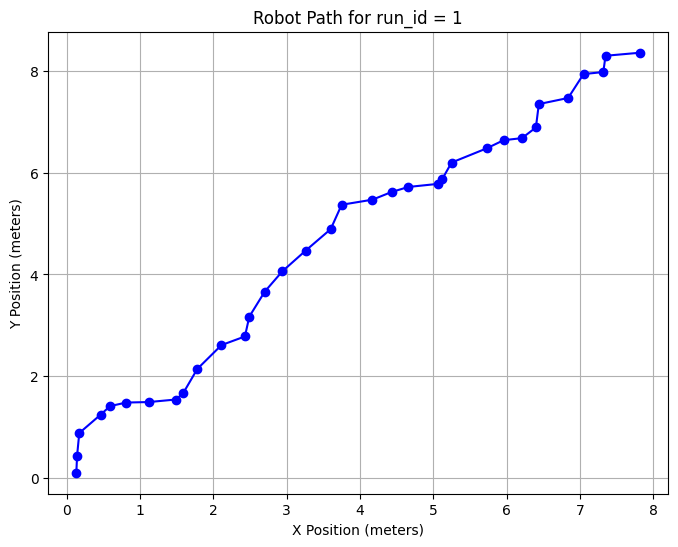

In [5]:


# Προβολή των πρώτων γραμμών
print(df.head())

# Βασικές πληροφορίες για το dataset
print(df.info())

# Περιγραφική στατιστική
print(df.describe())

# Οπτικοποίηση: θέση του ρομπότ (x, y) για το πρώτο run_id
run_id = 1
df_run = df[df['run_id'] == run_id]

plt.figure(figsize=(8,6))
plt.plot(df_run['x'], df_run['y'], marker='o', linestyle='-', color='b')
plt.title(f'Robot Path for run_id = {run_id}')
plt.xlabel('X Position (meters)')
plt.ylabel('Y Position (meters)')
plt.grid(True)
plt.show()


In [6]:

# Στατιστική περιγραφή αριθμητικών στηλών
print(df.describe())

# Έλεγχος για κενές τιμές
print(df.isnull().sum())

            run_id    timestamp    lidar_min    lidar_max  ultrasonic_left  \
count  3135.000000  3135.000000  3135.000000  3135.000000      3135.000000   
mean     49.868262    17.181499     0.820258     4.482105         1.048447   
std      28.421842    11.766931     0.465417     0.463787         0.559064   
min       1.000000     0.000000     0.300000     2.090000         0.100000   
25%      25.000000     7.000000     0.465000     4.250000         0.560000   
50%      52.000000    16.000000     0.690000     4.610000         1.040000   
75%      74.000000    26.000000     1.040000     4.840000         1.540000   
max     100.000000    49.000000     2.820000     5.000000         2.000000   

       ultrasonic_right            x            y  orientation  battery_level  \
count       3135.000000  3135.000000  3135.000000  3135.000000    3135.000000   
mean           1.055812     4.594434     4.518600   178.420986      86.463270   
std            0.548689     3.041495     2.991176   10

In [7]:
SAFE_DISTANCE = 0.5  # όριο απόστασης σε μέτρα

def decide_movement(ultrasonic_left, ultrasonic_right):
    if ultrasonic_left < SAFE_DISTANCE and ultrasonic_right < SAFE_DISTANCE:
        return 'stop'  # εμπόδιο μπροστά
    elif ultrasonic_left < SAFE_DISTANCE:
        return 'turn_right'
    elif ultrasonic_right < SAFE_DISTANCE:
        return 'turn_left'
    else:
        return 'forward'

df['movement_decision'] = df.apply(lambda row: decide_movement(row['ultrasonic_left'], row['ultrasonic_right']), axis=1)

print(df[['ultrasonic_left', 'ultrasonic_right', 'movement_decision', 'collision_flag']].head(20))


    ultrasonic_left  ultrasonic_right movement_decision  collision_flag
0              0.97              1.63           forward               0
1              0.95              0.82           forward               0
2              1.11              1.37           forward               0
3              1.24              0.86           forward               0
4              1.46              1.86           forward               0
5              1.16              1.55           forward               0
6              1.61              0.59           forward               0
7              0.78              1.69           forward               0
8              1.37              1.45           forward               0
9              1.73              0.94           forward               0
10             0.47              1.80        turn_right               0
11             1.54              1.80           forward               0
12             1.20              0.20         turn_left         

In [8]:
# Πόσες συγκρούσεις (collision_flag=1) υπάρχουν συνολικά;
total_collisions = df['collision_flag'].sum()
print(f"Συνολικές συγκρούσεις: {total_collisions}")

# Συγκρούσεις ανά κίνηση που προτείνει ο αλγόριθμος
collision_per_movement = df[df['collision_flag'] == 1]['movement_decision'].value_counts()
print("Συγκρούσεις ανά κίνηση:")
print(collision_per_movement)

# Ανάλυση κινήσεων χωρίς σύγκρουση
non_collision_per_movement = df[df['collision_flag'] == 0]['movement_decision'].value_counts()
print("Κινήσεις χωρίς σύγκρουση:")
print(non_collision_per_movement)


Συνολικές συγκρούσεις: 68
Συγκρούσεις ανά κίνηση:
movement_decision
forward       38
turn_right    14
turn_left     12
stop           4
Name: count, dtype: int64
Κινήσεις χωρίς σύγκρουση:
movement_decision
forward       1916
turn_right     523
turn_left      492
stop           136
Name: count, dtype: int64


In [9]:
distances = [0.3, 0.5, 0.7, 1.0]

for dist in distances:
    df['movement_decision'] = df.apply(
        lambda row: 'stop' if row['ultrasonic_left'] < dist and row['ultrasonic_right'] < dist
        else ('turn_right' if row['ultrasonic_left'] < dist
              else ('turn_left' if row['ultrasonic_right'] < dist else 'forward')),
        axis=1)
    
    collisions = df[df['collision_flag'] == 1]['movement_decision'].value_counts()
    print(f"SAFE_DISTANCE = {dist}")
    print("Συγκρούσεις ανά κίνηση:")
    print(collisions)
    print("-" * 30)


SAFE_DISTANCE = 0.3
Συγκρούσεις ανά κίνηση:
movement_decision
forward       52
turn_right    10
turn_left      4
stop           2
Name: count, dtype: int64
------------------------------
SAFE_DISTANCE = 0.5
Συγκρούσεις ανά κίνηση:
movement_decision
forward       38
turn_right    14
turn_left     12
stop           4
Name: count, dtype: int64
------------------------------
SAFE_DISTANCE = 0.7
Συγκρούσεις ανά κίνηση:
movement_decision
forward       25
turn_right    22
turn_left     12
stop           9
Name: count, dtype: int64
------------------------------
SAFE_DISTANCE = 1.0
Συγκρούσεις ανά κίνηση:
movement_decision
turn_right    19
stop          18
forward       17
turn_left     14
Name: count, dtype: int64
------------------------------


In [10]:
import pandas as pd



distances = [0.3, 0.5, 0.7, 1.0]

for dist in distances:
    def decide_movement(ultrasonic_left, ultrasonic_right):
        if ultrasonic_left < dist and ultrasonic_right < dist:
            return 'stop'
        elif ultrasonic_left < dist:
            return 'turn_right'
        elif ultrasonic_right < dist:
            return 'turn_left'
        else:
            return 'forward'
    
    df['movement_decision'] = df.apply(lambda row: decide_movement(row['ultrasonic_left'], row['ultrasonic_right']), axis=1)
    
    collisions = df[df['collision_flag'] == 1]['movement_decision'].value_counts()
    non_collisions = df[df['collision_flag'] == 0]['movement_decision'].value_counts()
    
    print(f"\nSAFE_DISTANCE = {dist}")
    print("Συγκρούσεις ανά κίνηση:")
    print(collisions)
    print("Κινήσεις χωρίς σύγκρουση:")
    print(non_collisions)
    print("-" * 50)



SAFE_DISTANCE = 0.3
Συγκρούσεις ανά κίνηση:
movement_decision
forward       52
turn_right    10
turn_left      4
stop           2
Name: count, dtype: int64
Κινήσεις χωρίς σύγκρουση:
movement_decision
forward       2457
turn_right     307
turn_left      272
stop            31
Name: count, dtype: int64
--------------------------------------------------

SAFE_DISTANCE = 0.5
Συγκρούσεις ανά κίνηση:
movement_decision
forward       38
turn_right    14
turn_left     12
stop           4
Name: count, dtype: int64
Κινήσεις χωρίς σύγκρουση:
movement_decision
forward       1916
turn_right     523
turn_left      492
stop           136
Name: count, dtype: int64
--------------------------------------------------

SAFE_DISTANCE = 0.7
Συγκρούσεις ανά κίνηση:
movement_decision
forward       25
turn_right    22
turn_left     12
stop           9
Name: count, dtype: int64
Κινήσεις χωρίς σύγκρουση:
movement_decision
forward       1445
turn_right     671
turn_left      648
stop           303
Name: count, dt

   run_id  timestamp  lidar_min  lidar_max  ultrasonic_left  ultrasonic_right  \
0       1          0       0.76       3.04             0.97              1.63   
1       1          1       2.16       4.84             0.95              0.82   
2       1          2       1.48       4.97             1.11              1.37   
3       1          3       0.66       4.32             1.24              0.86   
4       1          4       0.34       4.96             1.46              1.86   

      x     y  orientation  battery_level  collision_flag  path_smoothness  \
0  0.13  0.10       316.54          98.90               0             0.83   
1  0.14  0.43       253.94          98.32               0             0.83   
2  0.17  0.88       108.54          97.96               0             0.83   
3  0.46  1.24       314.48          97.26               0             0.83   
4  0.59  1.41       233.75          96.87               0             0.83   

   time_taken   target movement_decision  
0

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


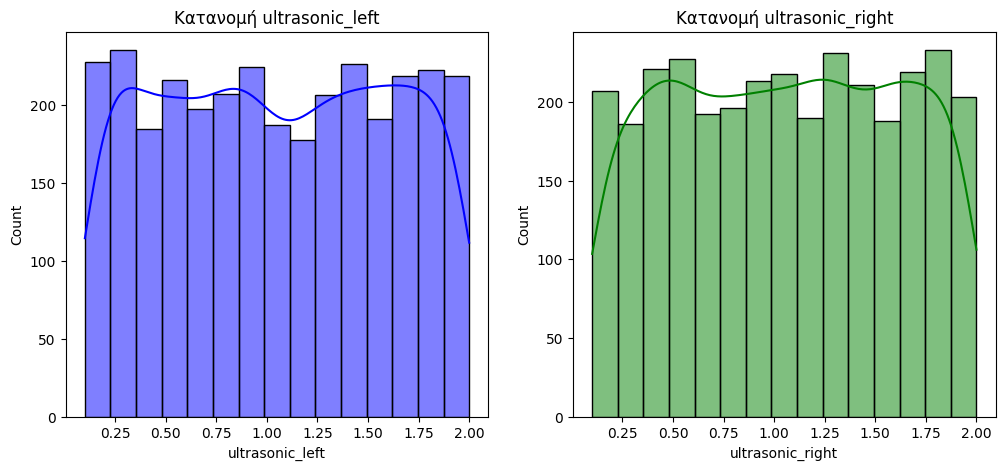

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


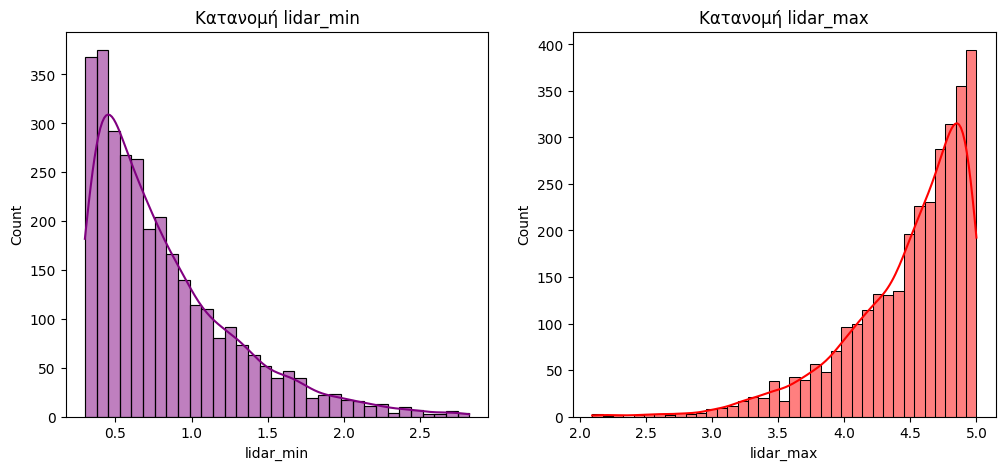

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


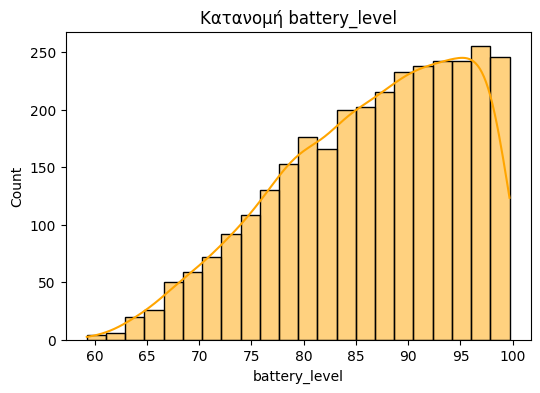

collision_flag
0    3067
1      68
Name: count, dtype: int64


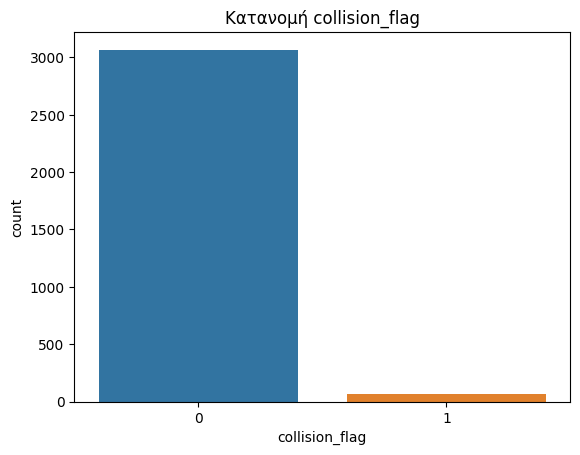

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Εμφάνιση πρώτων γραμμών
print(df.head())

# Περιγραφική στατιστική
print(df.describe())

# Έλεγχος για κενά δεδομένα
print(df.isnull().sum())

# Κατανομή τιμών για αισθητήρες υπερήχων
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df['ultrasonic_left'], kde=True, color='blue')
plt.title('Κατανομή ultrasonic_left')

plt.subplot(1,2,2)
sns.histplot(df['ultrasonic_right'], kde=True, color='green')
plt.title('Κατανομή ultrasonic_right')

plt.show()

# Κατανομή για lidar_min και lidar_max
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df['lidar_min'], kde=True, color='purple')
plt.title('Κατανομή lidar_min')

plt.subplot(1,2,2)
sns.histplot(df['lidar_max'], kde=True, color='red')
plt.title('Κατανομή lidar_max')

plt.show()

# Εξέταση της κατανομής της μπαταρίας
plt.figure(figsize=(6,4))
sns.histplot(df['battery_level'], kde=True, color='orange')
plt.title('Κατανομή battery_level')
plt.show()

# Εξέταση του collision_flag (πόσες συγκρούσεις)
print(df['collision_flag'].value_counts())
sns.countplot(x='collision_flag', data=df)
plt.title('Κατανομή collision_flag')
plt.show()


In [14]:
import pandas as pd

df = df.dropna(subset=['ultrasonic_left', 'ultrasonic_right', 'lidar_min', 'movement_decision'])  # Αφαίρεση κενών


In [15]:
df['movement_decision'] = df['movement_decision'].astype('category')


In [16]:
import plotly.express as px

fig = px.scatter_3d(
    df, 
    x='ultrasonic_left', 
    y='ultrasonic_right', 
    z='lidar_min',
    color='movement_decision',
    title='3D Visualization of Sensor Data vs Movement Decisions',
    labels={
        'ultrasonic_left': 'Ultrasonic Left (m)',
        'ultrasonic_right': 'Ultrasonic Right (m)',
        'lidar_min': 'LIDAR Min Distance (m)'
    },
    opacity=0.7
)

fig.update_layout(
    legend_title_text='Movement Decision',
    scene = dict(
        xaxis=dict(title='Ultrasonic Left'),
        yaxis=dict(title='Ultrasonic Right'),
        zaxis=dict(title='LIDAR Min')
    )
)

fig.show()


In [17]:
SAFE_DISTANCE = 0.5  # παράδειγμα τιμής σε μέτρα

def rule_based_decision(ultrasonic_left, ultrasonic_right):
    if ultrasonic_left < SAFE_DISTANCE and ultrasonic_right < SAFE_DISTANCE:
        return 'stop'            # εμπόδιο και στις δύο πλευρές
    elif ultrasonic_left < SAFE_DISTANCE:
        return 'turn_right'      # εμπόδιο αριστερά, στρίψε δεξιά
    elif ultrasonic_right < SAFE_DISTANCE:
        return 'turn_left'       # εμπόδιο δεξιά, στρίψε αριστερά
    else:
        return 'forward'         # ασφαλής πορεία προς τα εμπρός


In [18]:
df['predicted_decision'] = df.apply(
    lambda row: rule_based_decision(row['ultrasonic_left'], row['ultrasonic_right']),
    axis=1
)

# Για απλή αξιολόγηση σύγκρουσης
df['predicted_collision'] = df['predicted_decision'].apply(lambda x: 1 if x == 'stop' else 0)

from sklearn.metrics import classification_report

print(classification_report(df['collision_flag'], df['predicted_collision']))


              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3067
           1       0.03      0.06      0.04        68

    accuracy                           0.94      3135
   macro avg       0.50      0.51      0.50      3135
weighted avg       0.96      0.94      0.95      3135



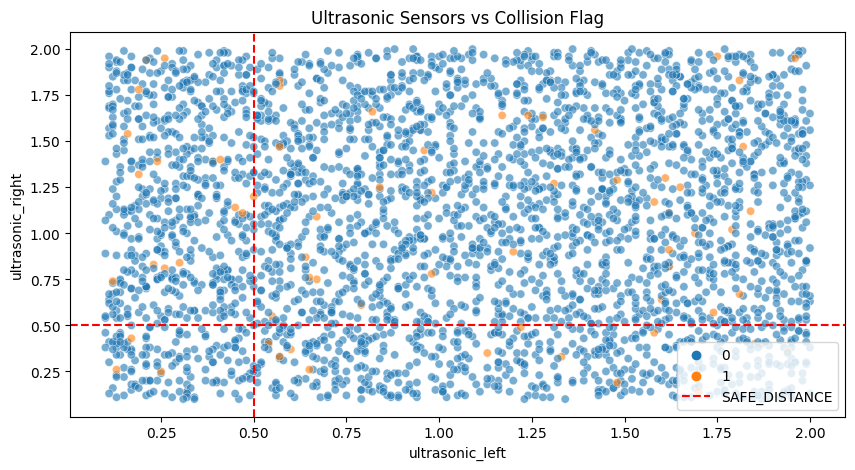

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.scatterplot(x='ultrasonic_left', y='ultrasonic_right', hue='collision_flag', data=df, alpha=0.6)
plt.axvline(SAFE_DISTANCE, color='red', linestyle='--', label='SAFE_DISTANCE')
plt.axhline(SAFE_DISTANCE, color='red', linestyle='--')
plt.title('Ultrasonic Sensors vs Collision Flag')
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



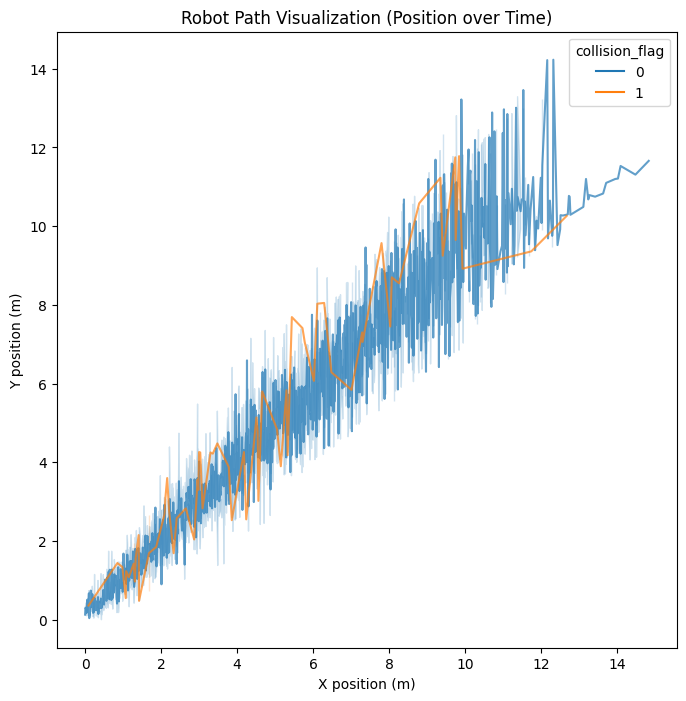

In [20]:
plt.figure(figsize=(8,8))
sns.lineplot(x='x', y='y', hue='collision_flag', data=df, alpha=0.7)
plt.title('Robot Path Visualization (Position over Time)')
plt.xlabel('X position (m)')
plt.ylabel('Y position (m)')
plt.show()


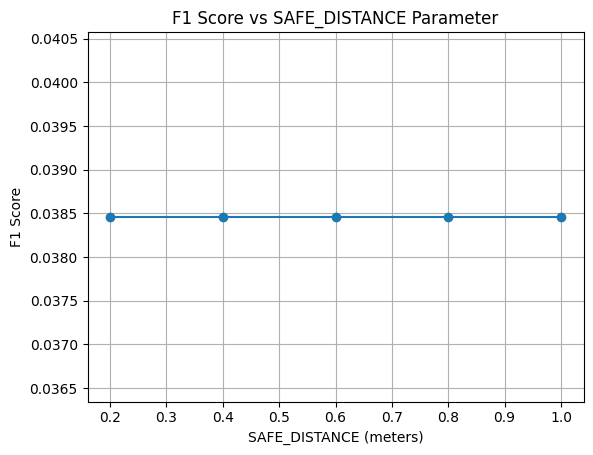

In [21]:
from sklearn.metrics import f1_score

safe_distances = [0.2, 0.4, 0.6, 0.8, 1.0]
scores = []

for sd in safe_distances:
    df['predicted_decision'] = df.apply(
        lambda row: rule_based_decision(row['ultrasonic_left'], row['ultrasonic_right']),
        axis=1
    )
    df['predicted_collision'] = df['predicted_decision'].apply(lambda x: 1 if x == 'stop' else 0)
    score = f1_score(df['collision_flag'], df['predicted_collision'])
    scores.append(score)

plt.plot(safe_distances, scores, marker='o')
plt.title('F1 Score vs SAFE_DISTANCE Parameter')
plt.xlabel('SAFE_DISTANCE (meters)')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()


In [22]:
features = ['ultrasonic_left', 'ultrasonic_right', 'lidar_min', 'lidar_max']
X = df[features]
y = df['movement_decision']  # ή y = df['collision_flag'] για ταξινόμηση σύγκρουσης


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

     forward       1.00      1.00      1.00       277
        stop       1.00      1.00      1.00       199
   turn_left       1.00      1.00      1.00       229
  turn_right       1.00      1.00      1.00       236

    accuracy                           1.00       941
   macro avg       1.00      1.00      1.00       941
weighted avg       1.00      1.00      1.00       941



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



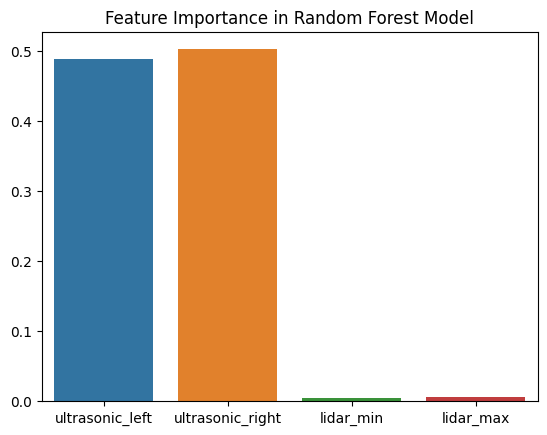

In [24]:
importances = clf.feature_importances_
sns.barplot(x=features, y=importances)
plt.title('Feature Importance in Random Forest Model')
plt.show()


Stats for ultrasonic_left when no collision:
count    3067.000000
mean        1.049941
std         0.558113
min         0.100000
25%         0.560000
50%         1.040000
75%         1.530000
max         2.000000
Name: ultrasonic_left, dtype: float64
Stats for ultrasonic_left when collision:
count    68.000000
mean      0.981029
std       0.600915
min       0.120000
25%       0.465000
50%       0.900000
75%       1.602500
max       1.960000
Name: ultrasonic_left, dtype: float64


Stats for ultrasonic_right when no collision:
count    3067.000000
mean        1.056609
std         0.549123
min         0.100000
25%         0.570000
50%         1.060000
75%         1.540000
max         2.000000
Name: ultrasonic_right, dtype: float64
Stats for ultrasonic_right when collision:
count    68.000000
mean      1.019853
std       0.531429
min       0.140000
25%       0.565000
50%       1.055000
75%       1.412500
max       1.960000
Name: ultrasonic_right, dtype: float64


Stats for lidar_min when n

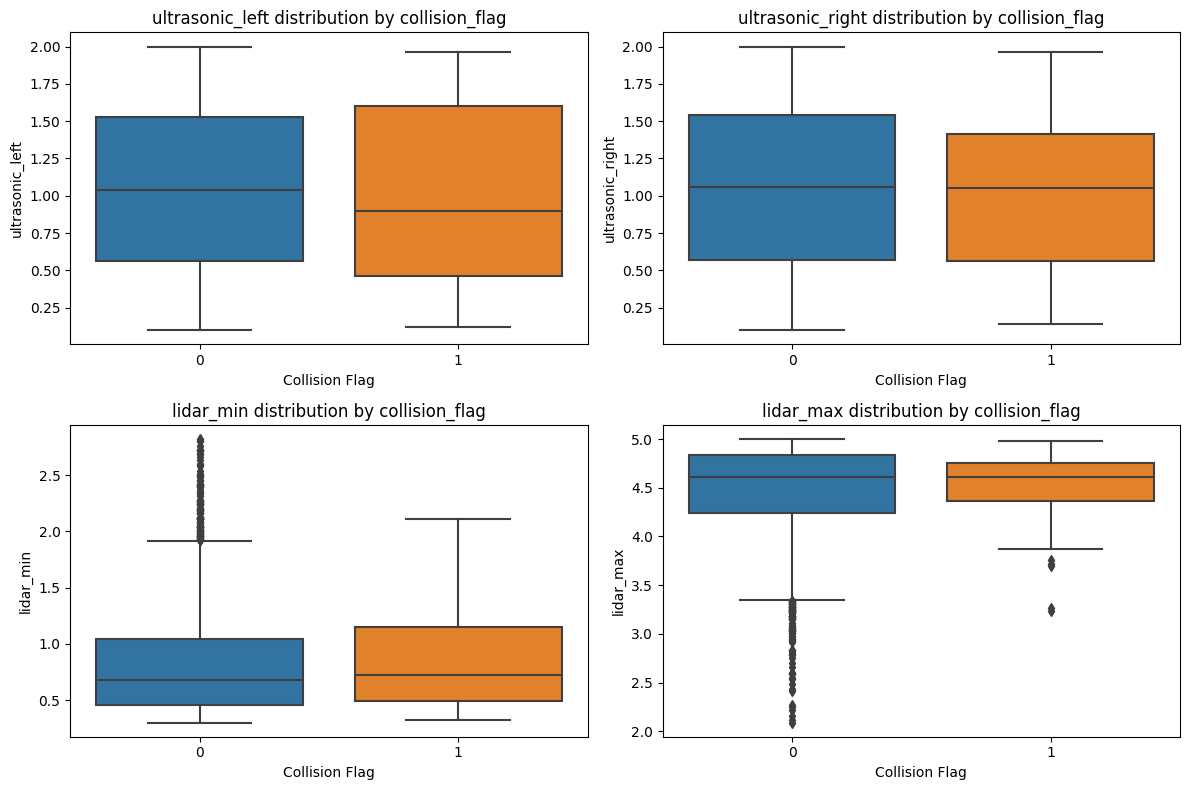

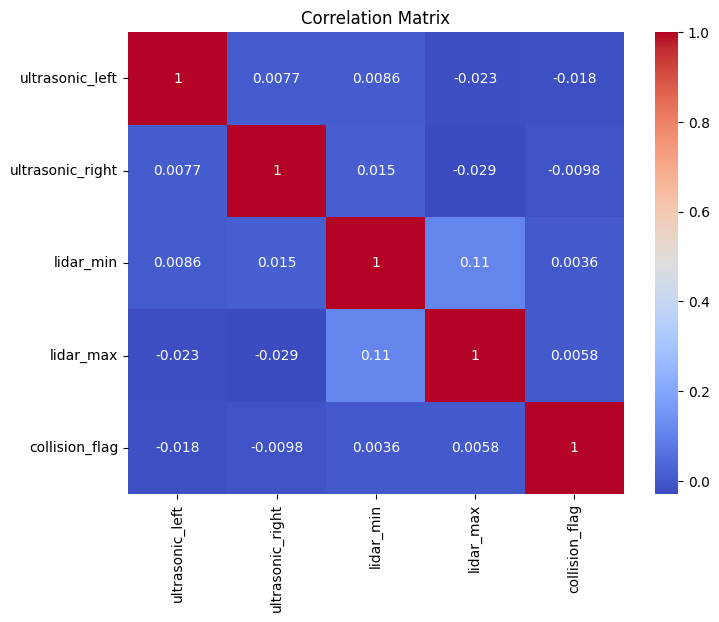

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# Φόρτωση δεδομένων (υποθέτουμε df το DataFrame)
sensors = ['ultrasonic_left', 'ultrasonic_right', 'lidar_min', 'lidar_max']
collision = 'collision_flag'

# Βασικά στατιστικά
for sensor in sensors:
    print(f"Stats for {sensor} when no collision:")
    print(df[df[collision]==0][sensor].describe())
    print(f"Stats for {sensor} when collision:")
    print(df[df[collision]==1][sensor].describe())
    print("\n")

# Υπολογισμός Pearson και Spearman
for sensor in sensors:
    pearson_corr, p_val_pearson = pearsonr(df[sensor], df[collision])
    spearman_corr, p_val_spearman = spearmanr(df[sensor], df[collision])
    print(f"{sensor} - Pearson r: {pearson_corr:.3f} (p={p_val_pearson:.3f}), Spearman r: {spearman_corr:.3f} (p={p_val_spearman:.3f})")

# Οπτικοποίηση με boxplots
plt.figure(figsize=(12,8))
for i, sensor in enumerate(sensors):
    plt.subplot(2,2,i+1)
    sns.boxplot(x=df[collision], y=df[sensor])
    plt.title(f'{sensor} distribution by collision_flag')
    plt.xlabel('Collision Flag')
    plt.ylabel(sensor)
plt.tight_layout()
plt.show()

# Heatmap συσχέτισης
plt.figure(figsize=(8,6))
sns.heatmap(df[sensors + [collision]].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


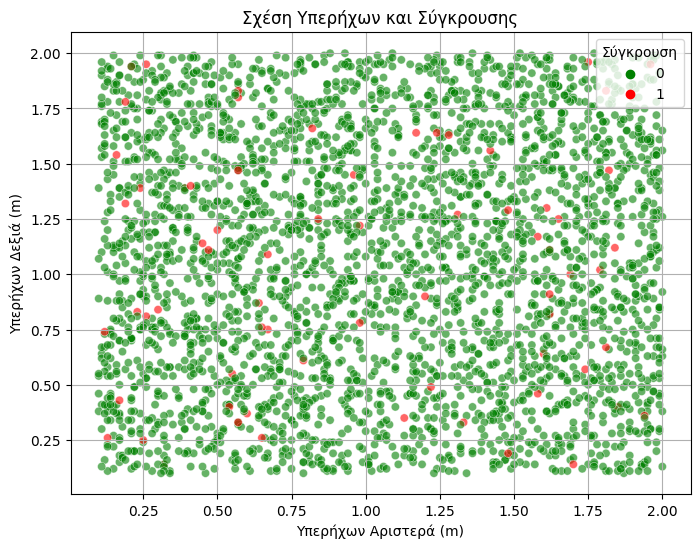

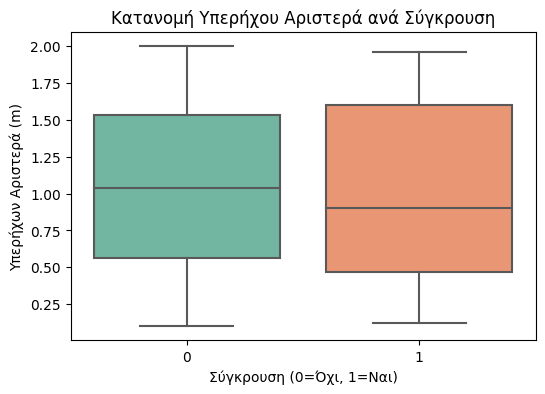

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot υπερήχων με σημειώσεις σύγκρουσης
plt.figure(figsize=(8,6))
sns.scatterplot(x='ultrasonic_left', y='ultrasonic_right', hue='collision_flag', data=df, palette={0:'green', 1:'red'}, alpha=0.6)
plt.title('Σχέση Υπερήχων και Σύγκρουσης')
plt.xlabel('Υπερήχων Αριστερά (m)')
plt.ylabel('Υπερήχων Δεξιά (m)')
plt.legend(title='Σύγκρουση')
plt.grid(True)
plt.show()

# Box plot υπερήχων αριστερά ανά σύγκρουση
plt.figure(figsize=(6,4))
sns.boxplot(x='collision_flag', y='ultrasonic_left', data=df, palette='Set2')
plt.title('Κατανομή Υπερήχου Αριστερά ανά Σύγκρουση')
plt.xlabel('Σύγκρουση (0=Όχι, 1=Ναι)')
plt.ylabel('Υπερήχων Αριστερά (m)')
plt.show()


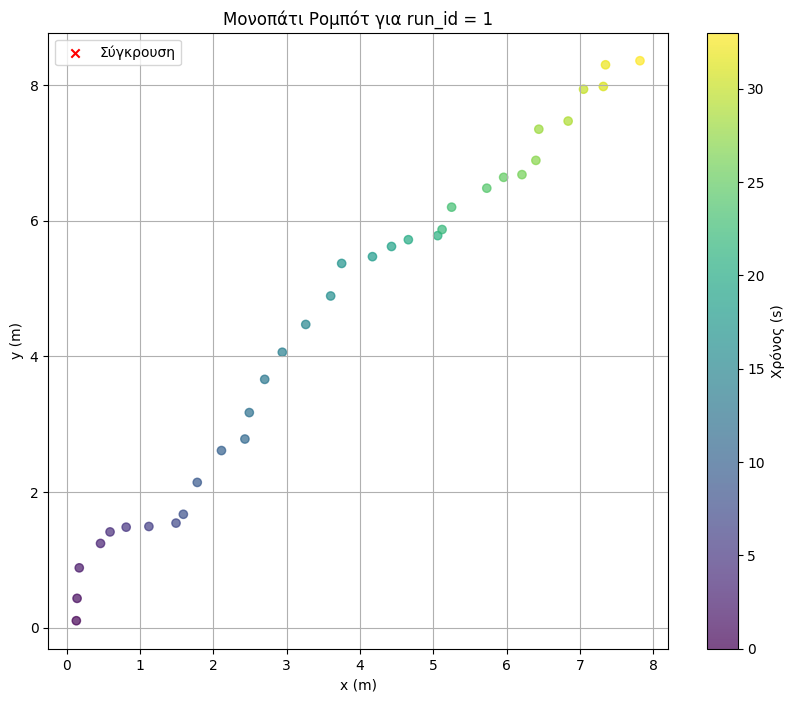

In [27]:
# Επιλογή ενός run_id για ανάλυση
run_to_plot = 1
df_run = df[df['run_id'] == run_to_plot]

plt.figure(figsize=(10,8))
scatter = plt.scatter(df_run['x'], df_run['y'], c=df_run['timestamp'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Χρόνος (s)')
# Σημειώνουμε σημεία σύγκρουσης
collision_points = df_run[df_run['collision_flag'] == 1]
plt.scatter(collision_points['x'], collision_points['y'], color='red', marker='x', label='Σύγκρουση')

plt.title(f'Μονοπάτι Ρομπότ για run_id = {run_to_plot}')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
import pandas as pd



# Ορίζουμε SAFE_DISTANCE
SAFE_DISTANCE = 0.5

# Δημιουργούμε νέα στήλη Near_Miss
df['near_miss'] = ((df['lidar_min'] < SAFE_DISTANCE) & (df['collision_flag'] == 0)).astype(int)

# Πόσα Near-Miss έχουμε;
print(f"Near-Miss count: {df['near_miss'].sum()}")


Near-Miss count: 886


In [32]:
window_size = 5  # πόσα προηγούμενα timestamps θα κοιτάξουμε

# Δημιουργούμε features με sliding windows για lidar_min και ultrasonic_left/right
for i in range(1, window_size + 1):
    df[f'lidar_min_t-{i}'] = df['lidar_min'].shift(i)
    df[f'ultrasonic_left_t-{i}'] = df['ultrasonic_left'].shift(i)
    df[f'ultrasonic_right_t-{i}'] = df['ultrasonic_right'].shift(i)

# Αφαιρούμε τις πρώτες γραμμές με NaN λόγω shift
df_windowed = df.dropna().reset_index(drop=True)

# Θα χρησιμοποιήσουμε αυτά τα features για το μοντέλο ή ανίχνευση ανωμαλιών
features = [f'lidar_min_t-{i}' for i in range(1, window_size + 1)] + \
           [f'ultrasonic_left_t-{i}' for i in range(1, window_size + 1)] + \
           [f'ultrasonic_right_t-{i}' for i in range(1, window_size + 1)]


In [33]:
from sklearn.ensemble import IsolationForest

# Επιλέγουμε μόνο τις γραμμές που δεν είναι Near-Miss ως "φυσιολογικά" δεδομένα για εκπαίδευση
normal_data = df_windowed[df_windowed['near_miss'] == 0]

iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(normal_data[features])

# Προβλέπουμε ανωμαλίες σε όλα τα δεδομένα
df_windowed['anomaly_score'] = iso_forest.decision_function(df_windowed[features])
df_windowed['anomaly'] = iso_forest.predict(df_windowed[features])
# -1 σημαίνει ανωμαλία, 1 σημαίνει φυσιολογικό

# Πόσες ανωμαλίες αντιστοιχούν σε Near-Miss;
print(pd.crosstab(df_windowed['near_miss'], df_windowed['anomaly']))


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



anomaly     -1     1
near_miss           
0          113  2132
1           45   840


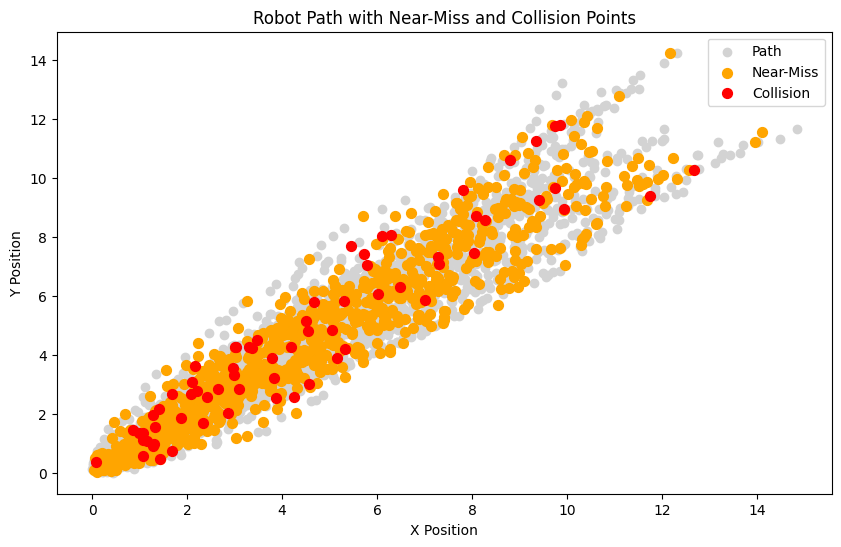

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df['x'], df['y'], c='lightgray', label='Path')
plt.scatter(df[df['near_miss'] == 1]['x'], df[df['near_miss'] == 1]['y'], color='orange', label='Near-Miss', s=50)
plt.scatter(df[df['collision_flag'] == 1]['x'], df[df['collision_flag'] == 1]['y'], color='red', label='Collision', s=50)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Robot Path with Near-Miss and Collision Points')
plt.legend()
plt.show()


Θα χρησιμοποιήσουμε συνδυασμό αισθητήρων (lidar_min + ultrasonic) και θα ορίσουμε Near-Miss με πολλαπλά κατώφλια, π.χ.

lidar_min < 0.5 m ΚΑΙ/Ή

ultrasonic_left ή ultrasonic_right < 0.6 m

collision_flag == 0

In [35]:
import numpy as np

df['speed'] = np.sqrt(df['x'].diff()**2 + df['y'].diff()**2) / df['timestamp'].diff()
df['acceleration'] = df['speed'].diff() / df['timestamp'].diff()

# Sliding windows για αισθητήρες + δυναμικά χαρακτηριστικά
window_size = 5
for i in range(1, window_size + 1):
    df[f'lidar_min_t-{i}'] = df['lidar_min'].shift(i)
    df[f'ultrasonic_left_t-{i}'] = df['ultrasonic_left'].shift(i)
    df[f'ultrasonic_right_t-{i}'] = df['ultrasonic_right'].shift(i)
    df[f'speed_t-{i}'] = df['speed'].shift(i)
    df[f'acceleration_t-{i}'] = df['acceleration'].shift(i)

df = df.dropna().reset_index(drop=True)


In [42]:
X = df[features]  # πχ οι στήλες με τα χαρακτηριστικά
y = df['target']  # ή όποια είναι η μεταβλητή στόχος


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



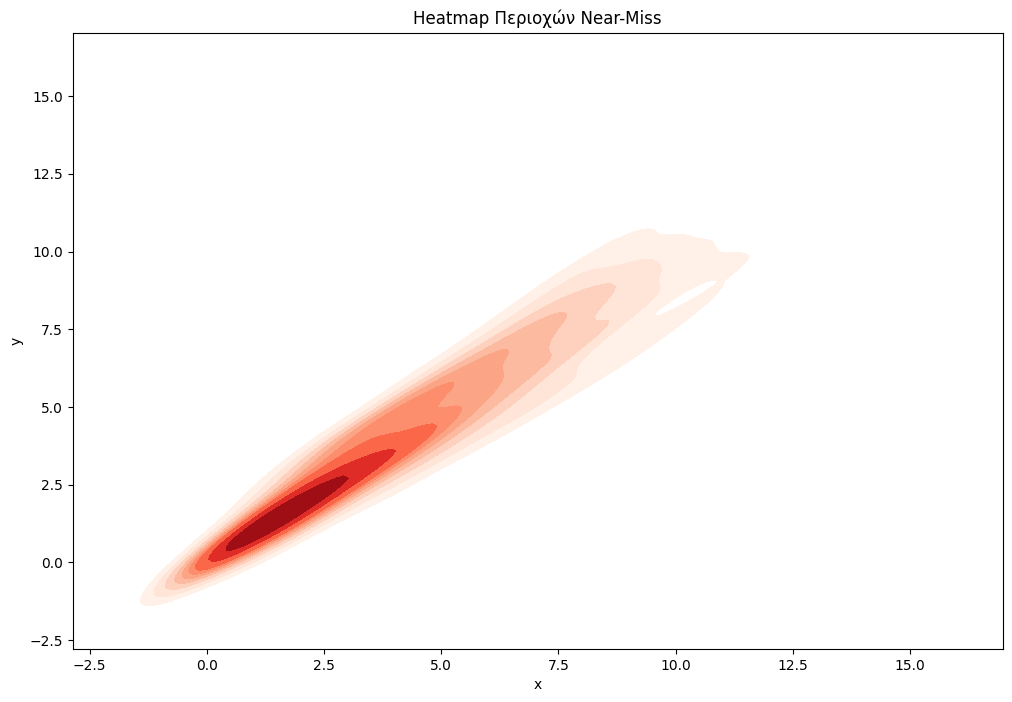

In [47]:
import seaborn as sns

plt.figure(figsize=(12,8))
sns.kdeplot(data=df[df['near_miss'] == 1], x='x', y='y', cmap="Reds", fill=True, thresh=0.1)
plt.title('Heatmap Περιοχών Near-Miss')
plt.show()


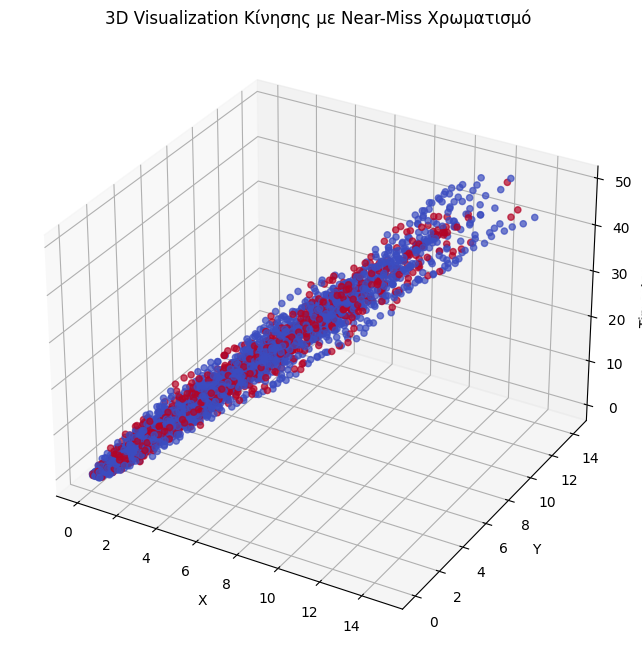

In [48]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x'], df['y'], df['timestamp'], c=df['near_miss'], cmap='coolwarm', alpha=0.7)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Timestamp')
plt.title('3D Visualization Κίνησης με Near-Miss Χρωματισμό')
plt.show()
